<a href="https://colab.research.google.com/github/xpurwar/Policy-Network--RL/blob/main/PolicyNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

In [1]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
#Give colab access to your google drive:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
#Change current directory to folder with MiniPacManGym.py
%cd /content/drive/MyDrive/Reinforcement Learning

/content/drive/MyDrive/Reinforcement Learning


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Import MiniPacMan environment class definition
from MiniPacManGym import MiniPacManEnv

In [8]:
#Register MiniPacMan in your gymnasium environments
register(
    id="MiniPacMan-v0",
    entry_point=MiniPacManEnv,
    max_episode_steps=20
)

In [9]:
#Create a MiniPacMan gymnasium environment
env = gym.make("MiniPacMan-v0", render_mode="human", frozen_ghost=True)

In [13]:
# neural net:
class NN(nn.Module):
    def __init__(self):
      super().__init__()
      # 6x6 is input
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(36, 16)
      self.activation1 = nn.ReLU()
      self.linear2 = nn.Linear(16, 4)
      self.softmax = nn.Softmax() # softmax layer turns the output into probabilites

    def forward(self, x):
      x = self.flatten(x)
      x = self.linear1(x)
      x = self.activation1(x)
      x = self.linear2(x)
      x = self.softmax(x)
      return x

p_net = NN()
test = torch.ones((1,6,6))
p_net(test)

tensor([[0.3649, 0.2702, 0.1772, 0.1877]], grad_fn=<SoftmaxBackward0>)

In [11]:
# random testing
obs = torch.ones((1,6,6))
actions = p_net(obs).detach().squeeze()
print(actions)
action = np.random.multinomial(1, actions)
print(action)

tensor([0.2398, 0.1809, 0.3430, 0.2363])
[1 0 0 0]


In [14]:
# Hyperparameters
gamma = 0.95
num_updates = 100
num_trajectories = 100
epsilon = 1
opt = torch.optim.Adam(p_net.parameters(), lr = 0.01)
win_rate = []

for e in range(num_updates):
    B = []  # Buffer to store log probs and total rewards
    win = 0

    for t in range(num_trajectories):
        new_obs, info = env.reset()
        new_obs = torch.tensor(new_obs, dtype=torch.float32).unsqueeze(0)  # Shape (1,6,6)
        done = False
        truncated = False
        T = []  # Trajectory buffer

        while not done and not truncated: # for one trajectory
            obs = new_obs

            # Choose action
            action_probs = p_net(obs)  # Forward pass
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            # Take action
            new_obs, reward, done, truncated, info = env.step(action.item())  # Ensure action is an integer
            new_obs = torch.tensor(new_obs, dtype=torch.float32).unsqueeze(0)

            # Store log probability and reward
            log_prob = action_dist.log_prob(action)
            T.append((log_prob, reward))
            #print(reward)

            if reward == 10:
              win += 1


        # Compute total discounted reward
        R = 0
        for log_prob, reward in reversed(T):  # Reverse iterate for discounting
            R = reward + gamma * R
            B.append((log_prob, torch.tensor(R, dtype=torch.float32)))  # Ensure R is a tensor

    win_percentage = (win / num_trajectories) * 100
    win_rate.append(win_percentage)

    # Compute policy loss using log probabilities
    policy_loss = torch.sum(torch.stack([-log_prob * R for log_prob, R in B])) / len(B)

    # Backpropagation
    opt.zero_grad()
    policy_loss.backward()
    opt.step()

    # Periodic reporting
    if e % 10 == 0:
        print(f'Update: {e}, Loss: {policy_loss.item():.4f}, Win rate: {win_percentage}')


Update: 0, Loss: -12.5362, Win rate: 0.0
Update: 10, Loss: -11.1942, Win rate: 2.0
Update: 20, Loss: -5.9273, Win rate: 15.0
Update: 30, Loss: -5.0492, Win rate: 20.0
Update: 40, Loss: 0.6982, Win rate: 62.0
Update: 50, Loss: 1.0467, Win rate: 78.0
Update: 60, Loss: 2.3895, Win rate: 94.0
Update: 70, Loss: 2.5016, Win rate: 98.0
Update: 80, Loss: 2.9330, Win rate: 100.0
Update: 90, Loss: 2.0506, Win rate: 99.0


In [15]:
#Run this code cell to see your trained agent in action!

obs, info = env.reset()
done = False
truncated = False

while not done and not truncated:
    env.render()
    obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    action_probs = p_net(obs)  # Forward pass
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    obs, reward, done, truncated, info = env.step(action)
    sleep(0.5)
    clear_output(wait=True)
env.render()
env.close()

xxxxxx
x····x
x··ᗣ·x
x····x
x···ᗧx
xxxxxx



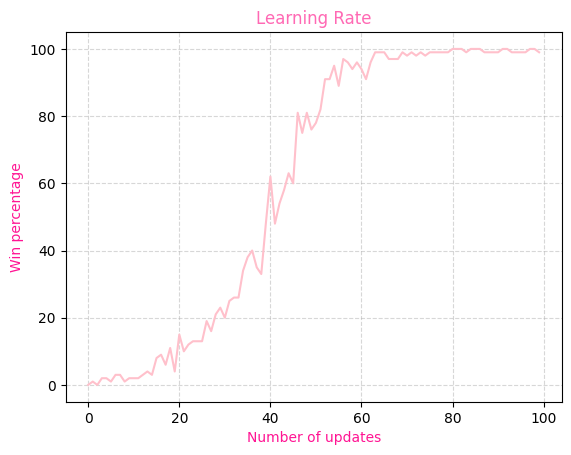

In [16]:
plt.plot(win_rate, color='pink')
plt.title("Learning Rate", color='hotpink')
plt.xlabel("Number of updates", color='deeppink')
plt.ylabel("Win percentage", color='deeppink')
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for visibility
plt.show()